In [2]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities, DiamondNorm
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from utils_qiskit import * 
from utils_plots import *

In [3]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

In [4]:
job_ids = [
            '5d9083dc79634830b84a122d6aabd1e7-16648063248694873',
            'eea890c98b394905a1f5a8d3122686d1-16648063283466015',
            '0ec013b625ec4f9d8b3fbd7f34b2f4fc-16648063318546033',
            '5f201e30ed3a435bb21bd5e0c8975766-16648063354740663',
            'eaf8374145974698a47690d3e69aadda-16648063389969826'
            ]

In [5]:
# qndmt_all = device_process_measurement_tomography( backend, parall_qubits=[] )
# circs = [ qndmt_all.circuits( name='all' ) ]

# qndnt_single = []
# for j in range(7):
#     qndmt = device_process_measurement_tomography( backend, qubits=[j], parall_qubits=[] )
#     qndnt_single.append( qndmt )
#     circs.append( qndmt.circuits( name='qubit_{}'.format(j) ) )

# circs = [ c for circ in circs for c in circ ]

In [6]:
# results_tomo = []

# for job_str in job_ids:

#     job = job_manager.retrieve_job_set( job_str, provider )
#     result_qiskit = job.results().combine_results()
#     save_results( result_qiskit, job_str)

#     results_tomo_job = [ qndmt_all.fit( result_qiskit, Func=2  ) ]
#     for j in range(7):
#         results_tomo_job.append(  qndnt_single[j].fit( result_qiskit, Func=2  ) ) 
#     np.save( 'data_v2'+job_str, np.array(results_tomo_job,dtype=object))

#     results_tomo.append( results_tomo_job )

In [7]:
# for job_str in job_ids[:1]:

#     job = job_manager.retrieve_job_set( job_str, provider )
#     result_qiskit = job.results().combine_results()
#     results_tomo_job = qndnt_single[j].fit( result_qiskit ) 

In [8]:
results_tomo = []

for job_str in job_ids:

    results_tomo.append( np.load( 'data_v2'+job_str+'.npy', allow_pickle=True) )

In [9]:
quantities_pa = []


for i in range(5):
    povms_pa = results_tomo[i][0].single.povms
    chois_pa= results_tomo[i][0].single.chois

    quantities_pa_temp = []
    for j in range(7):
        quantities_pa_temp.append( Quantities( povms_pa[j], chois_pa[j] ) )
    
    quantities_pa.append( quantities_pa_temp )


In [10]:
quantities_in = []
errors = []

for i in range(5):
    quantities_in_temp = []
    errors_temp = []

    povms_pa = results_tomo[i][0].single.povms
    chois_pa= results_tomo[i][0].single.chois

    for j in range(7):
        povms_pa = results_tomo[i][0].single.povms[j].reshape(2,2,2).transpose(2,0,1)
        chois_pa= results_tomo[i][0].single.chois[j]
        povms_in = results_tomo[i][j+1].single.povms[0]
        chois_in= results_tomo[i][j+1].single.chois[0]
        quantities_in_temp.append( Quantities( povms_in, chois_in ) )
        povms_in = povms_in.reshape(2,2,2).transpose(2,0,1)
        error_chois = 0.25*DiamondNorm( chois_in[0] - chois_pa[0], 'vec'  ) + .25*DiamondNorm( chois_in[1] -  chois_pa[1], 'vec'  )
        error_povm = 0.5*np.linalg.norm( povms_in[0] - povms_pa[0], 2 ) + 0.5*np.linalg.norm(povms_in[1] - povms_pa[1], 2 )

        errors_temp.append( [ error_povm, error_chois ] )
        
    quantities_in.append( quantities_in_temp )
    errors.append( errors_temp )


In [11]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size"  : 22,
    "font.sans-serif": ["Helvetica"]})

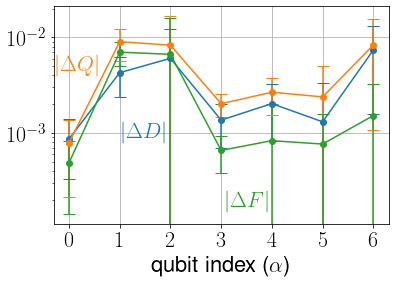

In [12]:
error_mean = np.mean( np.abs( np.array(quantities_pa)-np.array(quantities_in) ), axis=0  )
error_std  = np.std( np.abs( np.array(quantities_pa)-np.array(quantities_in) ), axis=0  )

#fig, ax = plt.subplots( figsize = (6.4, 4.8/2) )

for j in [2,1,0]:
    plt.errorbar( range(7), error_mean[:,j], error_std[:,j], fmt='-o', capsize=6 )
# plt.errorbar( range(7), np.mean(errors, axis=0), np.std(errors, axis=0), fmt='-o', capsize=6 )
plt.yscale('log')
plt.xlabel('qubit index ($\\alpha$)')
plt.xticks( [0,1,2,3,4,5,6] )
plt.grid()
plt.text( 3.1, 1.7e-4, '$|\\Delta F|$', color='tab:green' )
plt.text( -.25, 4.5e-3, '$|\\Delta Q|$', color='tab:orange' )
plt.text( 1.05, 0.9e-3, '$|\\Delta D|$', color='tab:blue' )
# plt.text( 2.8, 2e-2, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.savefig('pa_vs_ind_single_quantities_v2.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_single_quantities_v2.svg', bbox_inches='tight', transparent=True )


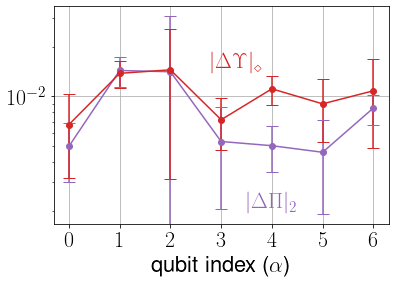

In [13]:
error_mean = np.mean(errors, axis=0)
error_std  = np.std(errors, axis=0)

#fig, ax = plt.subplots( figsize = (6.4, 4.8/2) )

plt.errorbar( range(7), error_mean[:,0], error_std[:,0] , fmt='-o', capsize=6, color='tab:purple' )
plt.errorbar( range(7), error_mean[:,1], error_std[:,1] , fmt='-o', capsize=6, color='tab:red' )
plt.yscale('log')
plt.xlabel('qubit index ($\\alpha$)')
plt.xticks( [0,1,2,3,4,5,6] )
plt.grid()
plt.text( 3.5, 2.1e-3, '$|\\Delta\\Pi|_2$', color='tab:purple' )
plt.text( 2.8, 1.5e-2, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.savefig('pa_vs_ind_single_error_v2.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_single_error_v2.svg', bbox_inches='tight', transparent=True )

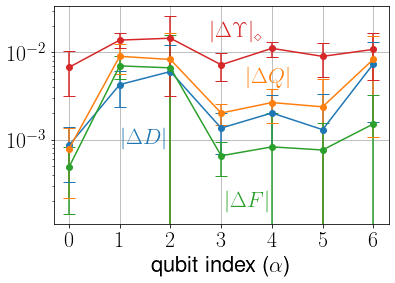

In [14]:
error_mean = np.mean( np.abs( np.array(quantities_pa)-np.array(quantities_in) ), axis=0  )
error_std  = np.std( np.abs( np.array(quantities_pa)-np.array(quantities_in) ), axis=0  )

error_mean2 = np.mean(errors, axis=0)
error_std2  = np.std(errors, axis=0)

#fig, ax = plt.subplots( figsize = (6.4, 4.8/2) )

for j in [2,1,0]:
    plt.errorbar( range(7), error_mean[:,j], error_std[:,j], fmt='-o', capsize=6 )
plt.errorbar( range(7), error_mean2[:,1], error_std2[:,1] , fmt='-o', capsize=6, color='tab:red' )
# plt.errorbar( range(7), np.mean(errors, axis=0), np.std(errors, axis=0), fmt='-o', capsize=6 )
plt.yscale('log')
plt.xlabel('qubit index ($\\alpha$)')
plt.xticks( [0,1,2,3,4,5,6] )
plt.grid()
plt.text( 3.1, 1.7e-4, '$|\\Delta F|$', color='tab:green' )
plt.text( 3.5, 4.5e-3, '$|\\Delta Q|$', color='tab:orange' )
plt.text( 1.05, 0.9e-3, '$|\\Delta D|$', color='tab:blue' )
plt.text( 2.8, 1.5e-2, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.savefig('pa_vs_ind_single_both_v2.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_single_both_v2.svg', bbox_inches='tight', transparent=True )

In [15]:
np.max( error_mean2[:,1] )

0.014526823320497984